# Julia Code Performance/Efficiency Comparison

This is a Jupyer Notebook that will compare the speed/efficiency of different Julia functions that practical perform the same opperation. These comparisons are not supposed to be super rigerous, nor  inclusive of all the methods to do a given opperation. Instead, it's more intended as a personal reference so I don't waste my time using inefficient processes in very large models and data sets. However, hopefully it can also serve as a useful reference to anyone else who wants to make their Julia code a little more efficient!

## Subsetting Dataframes

`@filter` macro from the Query.jl package 

vs. 

`subset` function in the Dataframes.jl package

vs.

`df[df.col .== condition, :]` approach with Dataframes.jl


Will be performing this on the zwillow housing price index for all gathered zip codes from 2000-2022. We will pivot the data so that it will have ~7.4 million rows to filter through. Our subsetting condition will be to obtain only housing value indicies from the city of New York. Because the third method cannot handle `missing` values, we will run two rounds of tests. One where the data has `missing` values, and a second where we replace all `missing` values with a string of "NA". We will also conduct a third test where we subset the data with multiple conditions over multiple columns.

### Round 1 - With missing values, One subset

We will start by loading the data in using `CSV.read()` function. However, Zwillow provides the housing data in a table format, where the dates are column names and the zip codes are row names. This makes it easy for humans to read but is a pain in the butt to manipulate using code. Therefore, we will also use the `stack()` function, to "pivot" the table so that the dates are in their own column.

In [14]:
using BenchmarkTools, Query, DataFrames, CSV
using Pipe: @pipe
#@btime zhvi = stack(DataFrame(CSV.File("data/zhvi_byzip_sm_sa_month.csv")),10:281)
zhvi = stack(CSV.read("data/zhvi_byzip_sm_sa_month.csv",DataFrame),10:281)
z = zhvi
first(zhvi,6)
names(zhvi)

11-element Vector{String}:
 "RegionID"
 "SizeRank"
 "RegionName"
 "RegionType"
 "StateName"
 "State"
 "City"
 "Metro"
 "CountyName"
 "variable"
 "value"

Here, "variable" is the date and "value" is the Zwillow Housing Value Index. They are not properly named due to the `stack()` pivot.

First let us test `@filter`. In the first test round, we will try subsetting the data once, so that the resulting data frame only has the housing values for New York City. In this trial, we will not remove `missing` values.

In [2]:
b11 = @benchmark(zhvi |> @filter(_.City == "New York") |> DataFrame)
times = DataFrame(method = "@filter", type = "with missing - 1 cond.", time = mean(b11.times))

,method,type,time
,String,String,Float64
1,@filter,with missing - 1 cond.,2.58527e9


Now we test `subset()`

In [3]:
b12 = @benchmark subset(zhvi, :City => c -> c .== "New York",skipmissing=true)
push!(times,["subset()","with missing - 1 cond.",mean(b12.times)])

,method,type,time
,String,String,Float64
1,@filter,with missing - 1 cond.,2.58527e9
2,subset(),with missing - 1 cond.,9.87876e7


### Round 2 - No Missing Values, One Condition
Now we will replace the `missing` values with the string "NA"

In [4]:
zhvi_nomiss = zhvi
zhvi_nomiss.City = replace(zhvi_nomiss.City, missing => "NA")
first(zhvi_nomiss,6)

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro
,Int64,Int64,Int64,String3,String3,String3,String,String?
1,91940,0,77449,zip,TX,TX,NA,"Houston-The Woodlands-Sugar Land, TX"
2,91982,1,77494,zip,TX,TX,NA,"Houston-The Woodlands-Sugar Land, TX"
3,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX"
4,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA"
5,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA"
6,95992,5,90011,zip,CA,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA"


Testing `@filter`

In [5]:
b21 = @benchmark(zhvi_nomiss |> @filter(_.City == "New York") |> DataFrame)
push!(times,["@filter","no missing - 1 cond.",mean(b21.times)])

,method,type,time
,String,String,Float64
1,@filter,with missing - 1 cond.,2.58527e9
2,subset(),with missing - 1 cond.,9.87876e7
3,@filter,no missing - 1 cond.,2.16561e9


Using `subset()`

In [6]:
b22 = @benchmark subset(zhvi_nomiss, :City => c -> c .== "New York",skipmissing=false)
push!(times,["subset()","no missing - 1 cond.",mean(b22.times)])

,method,type,time
,String,String,Float64
1,@filter,with missing - 1 cond.,2.58527e9
2,subset(),with missing - 1 cond.,9.87876e7
3,@filter,no missing - 1 cond.,2.16561e9
4,subset(),no missing - 1 cond.,1.11186e8


Now using bracket conditions

In [7]:
b23 = @benchmark zhvi_nomiss[zhvi_nomiss.City .== "New York",:]
push!(times,["brackets","no missing - 1 cond.",mean(b23.times)])

,method,type,time
,String,String,Float64
1,@filter,with missing - 1 cond.,2.58527e9
2,subset(),with missing - 1 cond.,9.87876e7
3,@filter,no missing - 1 cond.,2.16561e9
4,subset(),no missing - 1 cond.,1.11186e8
5,brackets,no missing - 1 cond.,9.14419e7


### Round 3 - No Missing, Multiple Conditions

Here we will condition that the city must be New York, that the Size Rank must be greater than 50, and that the zip code must be odd.

Testing `@filter`

In [8]:
b31 = @benchmark(zhvi_nomiss |> @filter(_.City == "New York" && _.SizeRank > 50 && isodd(_.RegionName)) |> DataFrame)
push!(times,["@filter","no missing - mult cond.",mean(b31.times)])

,method,type,time
,String,String,Float64
1,@filter,with missing - 1 cond.,2.58527e9
2,subset(),with missing - 1 cond.,9.87876e7
3,@filter,no missing - 1 cond.,2.16561e9
4,subset(),no missing - 1 cond.,1.11186e8
5,brackets,no missing - 1 cond.,9.14419e7
6,@filter,no missing - mult cond.,2.21444e9


Using `subset()`

In [9]:
b32 = @benchmark subset(zhvi_nomiss, :City => c -> c .== "New York",:SizeRank => size -> size .> 50, :RegionName => zip -> isodd.(zip),skipmissing=false)
push!(times,["subset()","no missing - mult cond.",mean(b32.times)])

,method,type,time
,String,String,Float64
1,@filter,with missing - 1 cond.,2.58527e9
2,subset(),with missing - 1 cond.,9.87876e7
3,@filter,no missing - 1 cond.,2.16561e9
4,subset(),no missing - 1 cond.,1.11186e8
5,brackets,no missing - 1 cond.,9.14419e7
6,@filter,no missing - mult cond.,2.21444e9
7,subset(),no missing - mult cond.,1.60164e8


Using bracket conditions

In [10]:
b33 = @benchmark zhvi_nomiss[(zhvi_nomiss.City .== "New York") .&& (zhvi_nomiss.SizeRank .> 50) .&& (isodd.(zhvi_nomiss.RegionName)),:]
push!(times,["brackets","no missing - mult cond.",mean(b33.times)])

,method,type,time
,String,String,Float64
1,@filter,with missing - 1 cond.,2.58527e9
2,subset(),with missing - 1 cond.,9.87876e7
3,@filter,no missing - 1 cond.,2.16561e9
4,subset(),no missing - 1 cond.,1.11186e8
5,brackets,no missing - 1 cond.,9.14419e7
6,@filter,no missing - mult cond.,2.21444e9
7,subset(),no missing - mult cond.,1.60164e8
8,brackets,no missing - mult cond.,1.11657e8


### Conclusion

We can plot the average compuation time of each method for each condition, using the "VegaLite.jl" package.

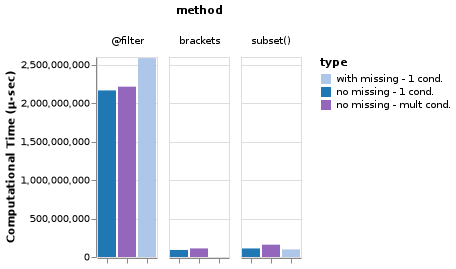

In [12]:
using VegaLite
comp = times |>
@vlplot(
    :bar,
    column = :method,
    x = {:type, axis={title="", labels =false}},
    y = {:time, axis={title="Computational Time (μ-sec)", grid = true}},
    color={
        :type,
        scale={
            domain=["with missing - 1 cond.","no missing - 1 cond.","no missing - mult cond."],
            range=["#aec7e8","#1f77b4","#9467bd"]
        }
    },
    spacing=10,
    config={
        views={stroke=:transparent},
        axis={domainWidth=1}
    }
)
comp

As you can see, the @filter function is very strange. First of all, it is dramatically slower than both DataFrame methods. This is honestly unfortunate because I really prefer the syntax of the Query method. The strange thing to observe is that the `@filter` macro became quicker with the more conditions it was told to filter, literally decreasing it's computation time. I have no idea why this would be true.

## More Data Cleaning - DataFrames vs. Query

I feel like the methods used in `Query.js` could be slower than using the built in functions from the `DataFrames.jl` package because it copies data multiple times, where DataFrames writes on an existing object. However, to test this, let us test other functions that are similar between the two.

### Renaming Variables in a DataFrame

We will start by trying to renaming variables in the data frame by using two different methods: the `@Rename` macro from the `Query` package, and the `rename()` package from the `DataFrames` package.


In [15]:

@btime z |>
    @rename(:variable => :date, :value  => :house_price_index, :RegionName => :zip) |>
    DataFrame


  4.018 s (14904106 allocations: 2.21 GiB)

,RegionID,SizeRank,zip,RegionType,StateName,State,City,Metro
,Int64,Int64,Int64,String3,String3,String3,String31?,String?
1,91940,0,77449,zip,TX,TX,missing,"Houston-The Woodlands-Sugar Land, TX"
2,91982,1,77494,zip,TX,TX,missing,"Houston-The Woodlands-Sugar Land, TX"
3,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX"
4,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA"
5,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA"
6,95992,5,90011,zip,CA,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA"
7,84630,6,60629,zip,IL,IL,Chicago,"Chicago-Naperville-Elgin, IL-IN-WI"
8,91733,7,77084,zip,TX,TX,Houston,"Houston-The Woodlands-Sugar Land, TX"
9,96361,8,91331,zip,CA,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA"


In [16]:
@btime rename(z,:variable => :date, :value => :house_price_index, :RegionName => :zip)

  1.569 s (72 allocations: 867.03 MiB)


,RegionID,SizeRank,zip,RegionType,StateName,State,City,Metro
,Int64,Int64,Int64,String3,String3,String3,String31?,String?
1,91940,0,77449,zip,TX,TX,missing,"Houston-The Woodlands-Sugar Land, TX"
2,91982,1,77494,zip,TX,TX,missing,"Houston-The Woodlands-Sugar Land, TX"
3,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX"
4,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA"
5,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA"
6,95992,5,90011,zip,CA,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA"
7,84630,6,60629,zip,IL,IL,Chicago,"Chicago-Naperville-Elgin, IL-IN-WI"
8,91733,7,77084,zip,TX,TX,Houston,"Houston-The Woodlands-Sugar Land, TX"
9,96361,8,91331,zip,CA,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA"


When comparing the two functions, there is much less of a difference when compared to the subsetting functions. Where the subset functions were of orders of magnitude different in terms of computation time, the difference between the renaming functions is much smaller. That being said, the rename function was still about 3x faster than the @rename macro. 

When testing this, I accidentially forgot to convert the macro back into a dataframe. When I did that, the resulting code excutation time was in terms of micro seconds, instead of the seconds. This lends creadence to my theorey that is the reulting conversion back to a dataframe that is slowing down the `Query` macros.

### Selecting/Removing Columns from a DataFrame

Here we will compare the times to remove columns from a dataframe. Again we will use the `@select` macro from the `Query` package, as well as the `select()` function from the `DataFrame` package.

In [17]:
@btime z |> @select(-:SizeRank, -:StateName, -:RegionType, -:RegionID) |> DataFrame

  3.386 s (14904086 allocations: 2.04 GiB)


,RegionName,State,City,Metro,CountyName
,Int64,String3,String31?,String?,String31
1,77449,TX,missing,"Houston-The Woodlands-Sugar Land, TX",Harris County
2,77494,TX,missing,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County
3,79936,TX,El Paso,"El Paso, TX",El Paso County
4,11368,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County
5,11385,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County
6,90011,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County
7,60629,IL,Chicago,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County
8,77084,TX,Houston,"Houston-The Woodlands-Sugar Land, TX",Harris County
9,91331,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County


In [18]:
@btime select(z,Not(:SizeRank), Not(:StateName), Not(:RegionType), Not(:RegionID))

  2.184 s (245 allocations: 867.04 MiB)

,RegionID,RegionName,RegionType,StateName,State,City,Metro
,Int64,Int64,String3,String3,String3,String31?,String?
1,91940,77449,zip,TX,TX,missing,"Houston-The Woodlands-Sugar Land, TX"
2,91982,77494,zip,TX,TX,missing,"Houston-The Woodlands-Sugar Land, TX"
3,93144,79936,zip,TX,TX,El Paso,"El Paso, TX"
4,62080,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA"
5,62093,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA"
6,95992,90011,zip,CA,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA"
7,84630,60629,zip,IL,IL,Chicago,"Chicago-Naperville-Elgin, IL-IN-WI"
8,91733,77084,zip,TX,TX,Houston,"Houston-The Woodlands-Sugar Land, TX"
9,96361,91331,zip,CA,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA"


The difference between these two methods is small, but again the DataFrame function of `select()` edges the `Query` macro in terms of performance.

In [19]:
# don't run this again, full time was 44m, compute time was 821s
using Dates
#@btime z |> @mutate(variable = Date(_.variable,DateFormat("y-m-d"))) |> DataFrame

In [20]:
# I don't know why but converting files into dates using the Date. package is incredibly intensive
# I will try to find a different package to convert dates, or find a different methods
#@btime transform(z,:variable => (time -> Date.(time,DateFormat("y-m-d"))))